In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np


def filter_academic_year(df, year):
    """Filter dataframe by academic year and drop AcademicYear column"""
    filtered_df = df[df["AcademicYear"] == year].copy()
    return filtered_df.drop(columns=["AcademicYear"])


def standarized_columns(acgr_df, mapping):
    """Rename ACGR columns to match Census Day naming convention"""
    renamed_df = acgr_df.copy()
    new_columns = {}

    for col in acgr_df.columns:
        parts = col.split(".")
        if len(parts) == 2 and parts[1] in mapping:
            new_col = f"{parts[0]}.{mapping[parts[1]]}"
            new_columns[col] = new_col

    return renamed_df.rename(columns=new_columns)


census_to_acgr_mapping = {
    # Race/Ethnicity
    "RE_B": "RB",  # African American
    "RE_I": "RI",  # American Indian or Alaska Native
    "RE_A": "RA",  # Asian
    "RE_F": "RF",  # Filipino
    "RE_H": "RH",  # Hispanic or Latino
    "RE_D": "RD",  # Not Reported
    "RE_P": "RP",  # Pacific Islander
    "RE_T": "RT",  # Two or More Races
    "RE_W": "RW",  # White
    # Gender
    "GN_M": "GM",  # Male
    "GN_F": "GF",  # Female
    "GN_X": "GX",  # Non-Binary
    "GN_Z": "GZ",  # Missing Gender
    # Student Groups
    "SG_EL": "SE",  # English Learners
    "SG_DS": "SD",  # Students with Disabilities
    "SG_SD": "SS",  # Socioeconomically Disadvantaged
    "SG_MG": "SM",  # Migrant
    "SG_FS": "SF",  # Foster
    "SG_HM": "SH",  # Homeless
    # Total
    "TA": "TA",  # Total
}

In [3]:
from functools import reduce

# Get tables
census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide", con)
ela_scores = pd.read_sql_query("SELECT * FROM ELAWide", con)
math_scores = pd.read_sql_query("SELECT * FROM MathWide", con)
public_schools = pd.read_sql_query("SELECT * FROM PublicSchools", con)

grade_cols_to_keep = ["GR_09", "GR_10", "GR_11", "GR_12"]
cols_to_keep = [
    col
    for col in census_day.columns
    if not col.startswith("GR_") or any(col.startswith(g) for g in grade_cols_to_keep)
]
census_day = census_day[cols_to_keep]

pattern = "Virtual|Magnet|YearRound|Multilingual"
public_schools = public_schools.filter(regex=pattern)
census_day_standardized = standarized_columns(census_day, census_to_acgr_mapping)


def add_suffix_except(df, suffix, exclude=("SchoolCode", "AcademicYear")):
    return df.rename(
        columns={col: f"{col}{suffix}" for col in df.columns if col not in exclude}
    )


ela_scores_suffixed = add_suffix_except(ela_scores, "_ELA")
math_scores_suffixed = add_suffix_except(math_scores, "_Math")

# Reduce columns
census_day_reduced = census_day.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)
acgr_reduced = acgr.drop(columns=["DistrictCode", "CountyCode"], errors="ignore")
ela_scores_reduced = ela_scores_suffixed.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)
math_scores_reduced = math_scores_suffixed.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)

# Merge DataFrames
dfs = [
    census_day_reduced,
    acgr_reduced,
    ela_scores_reduced,
    math_scores_reduced,
]

merged = reduce(
    lambda left, right: pd.merge(left, right, on="SchoolCode", how="inner"), dfs
)
merged

,AcademicYear,SchoolCode,Charter,TOTAL_ENR.GN_F,GR_09.GN_F,GR_10.GN_F,GR_11.GN_F,GR_12.GN_F,TOTAL_ENR.GN_M,GR_09.GN_M,...,currdenom.SWD_Math,currstatus.SWD_Math,currdenom.WH_Math,currstatus.WH_Math,currdenom.PI_Math,currstatus.PI_Math,currdenom.AI_Math,currstatus.AI_Math,currdenom.HOM_Math,currstatus.HOM_Math
0,2023-24,131755,N,21.0,0.0,0.0,0.0,0.0,28.0,0.0,...,19.0,-168.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-24,131755,N,21.0,0.0,0.0,0.0,0.0,28.0,0.0,...,22.0,-204.7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-24,131755,N,21.0,0.0,0.0,0.0,0.0,28.0,0.0,...,25.0,-182.1,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,2023-24,131755,N,21.0,0.0,0.0,0.0,0.0,28.0,0.0,...,19.0,-131.1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,2023-24,131755,N,21.0,0.0,0.0,0.0,0.0,28.0,0.0,...,19.0,-168.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444531,2022-23,5838305,None,477.0,118.0,116.0,133.0,110.0,570.0,149.0,...,36.0,-197.0,110.0,-73.9,2.0,NaN,2.0,NaN,11.0,-141.1
2444532,2022-23,5838305,None,477.0,118.0,116.0,133.0,110.0,570.0,149.0,...,32.0,-189.6,84.0,-104.0,4.0,NaN,3.0,NaN,4.0,NaN
2444533,2022-23,5838305,None,477.0,118.0,116.0,133.0,110.0,570.0,149.0,...,28.0,-221.3,83.0,-79.0,1.0,NaN,3.0,NaN,2.0,NaN
2444534,2022-23,5838305,None,477.0,118.0,116.0,133.0,110.0,570.0,149.0,...,17.0,-225.9,73.0,-42.3,1.0,NaN,1.0,NaN,1.0,NaN


In [4]:
for col in merged.columns:
    if any(substr in col for substr in ["Rate", "Percent", "ENR", "GR_"]):
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

academic_years = [
    "2017-18",
    "2018-19",
    "2019-20",
    "2020-21",
    "2021-22",
    "2022-23",
    "2023-24",
]

columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("RegHSDiploma")
    or col.startswith("Dropout")
    or col.startswith("UniReqs")
    or col.startswith("currstatus")
    or col.startswith("currdenom")
    or col.startswith("Other")
]

year_df_mapping = {year: filter_academic_year(merged, year) for year in academic_years}

## XGBoost

### Math

In [5]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "currstatus.ALL_Math"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result

Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.2953 ± 0.1049
MAE: 18.9115 ± 0.0582
R^2: 0.8544 ± 0.0018
Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.2286 ± 0.1321
MAE: 18.9326 ± 0.0787
R^2: 0.8544 ± 0.0009
Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.1287 ± 0.1098
MAE: 18.9147 ± 0.0457
R^2: 0.8549 ± 0.0015
Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.2432 ± 0.1244
MAE: 18.8731 ± 0.0812
R^2: 0.8554 ± 0.0017
Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.1241 ± 0.0745
MAE: 18.8190 ± 0.0511
R^2: 0.8562 ± 0.0010
Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.2322 ± 0.0676
MAE: 18.9275 ± 0.0589
R^2: 0.8546 ± 0.0008
Cross-Validation Results for currstatus.ALL_Math (5 folds) for 2023-24:
RMSE: 25.2247 ± 0.0845
MAE: 18.8940 ± 0.0712
R^2: 0.8554 ± 0.0018


<Figure size 1400x600 with 0 Axes>

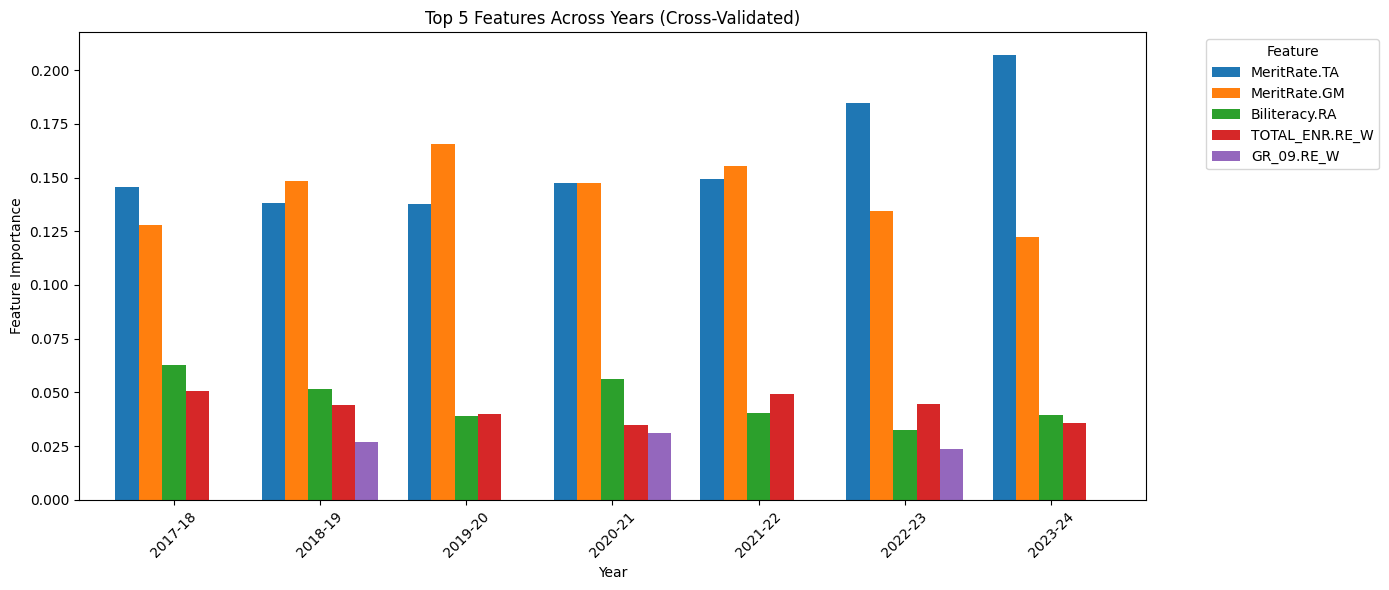

<Figure size 1400x600 with 0 Axes>

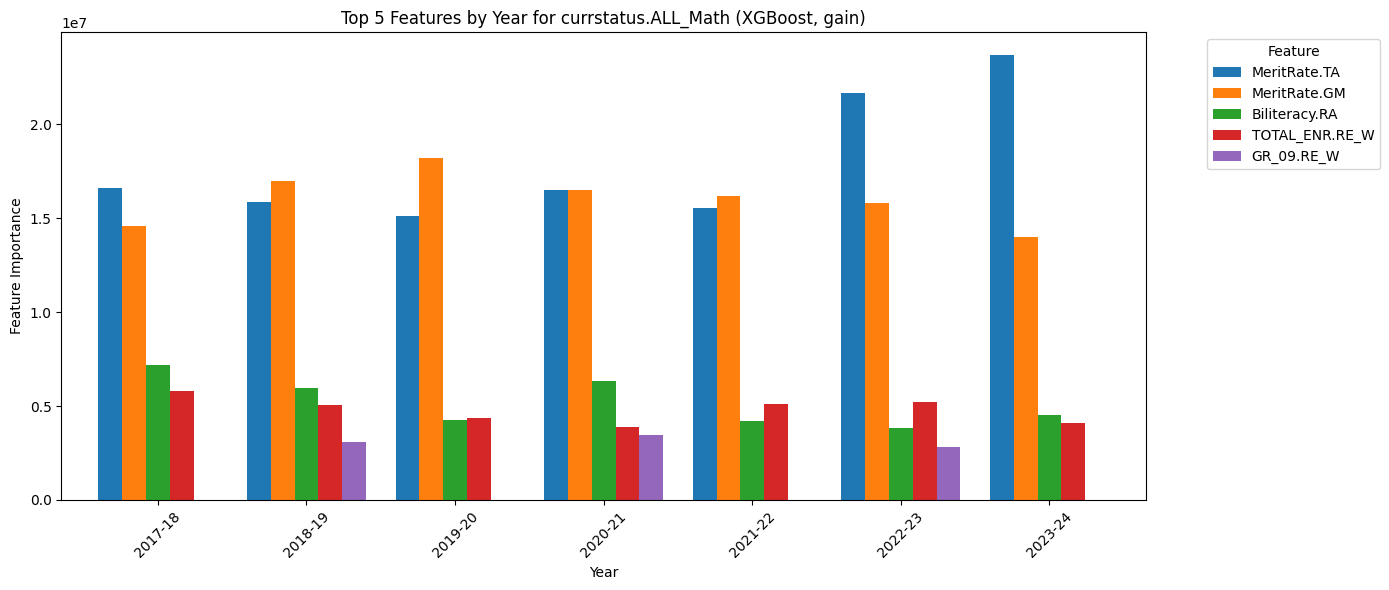

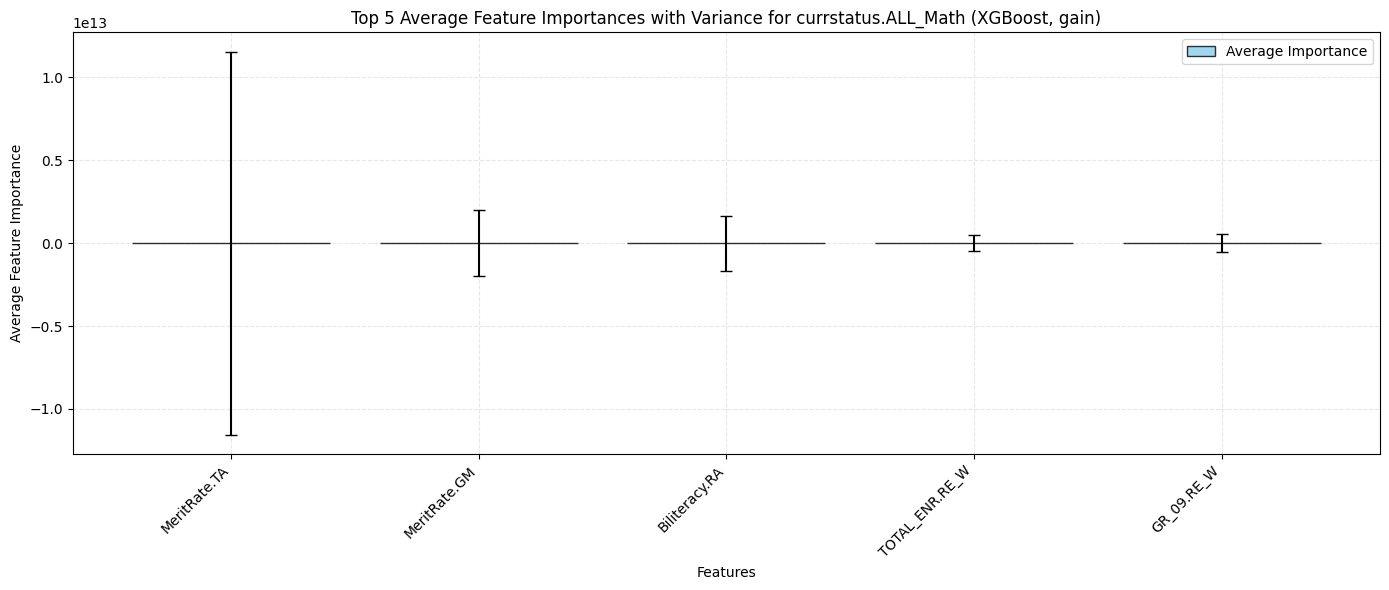

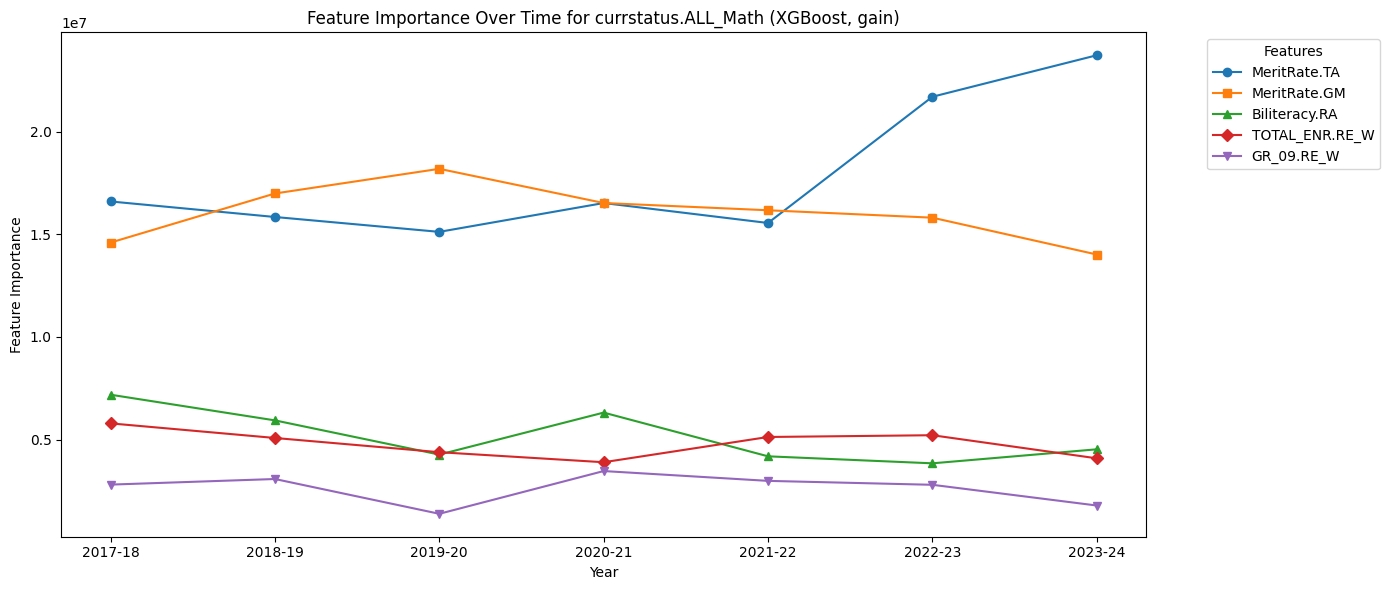

In [6]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features
)

### ELA

In [7]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "currstatus.ALL_ELA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result

Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.3608 ± 0.1102
MAE: 19.1286 ± 0.0561
R^2: 0.7830 ± 0.0024
Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.2469 ± 0.0654
MAE: 19.1103 ± 0.0168
R^2: 0.7849 ± 0.0016
Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.3067 ± 0.1197
MAE: 19.0636 ± 0.0578
R^2: 0.7854 ± 0.0020
Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.2523 ± 0.1276
MAE: 19.0996 ± 0.0370
R^2: 0.7856 ± 0.0013
Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.2026 ± 0.0734
MAE: 18.9473 ± 0.0471
R^2: 0.7883 ± 0.0008
Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.3572 ± 0.1099
MAE: 19.0938 ± 0.0509
R^2: 0.7859 ± 0.0015
Cross-Validation Results for currstatus.ALL_ELA (5 folds) for 2023-24:
RMSE: 27.2186 ± 0.1406
MAE: 19.0605 ± 0.0620
R^2: 0.7866 ± 0.0021


<Figure size 1400x600 with 0 Axes>

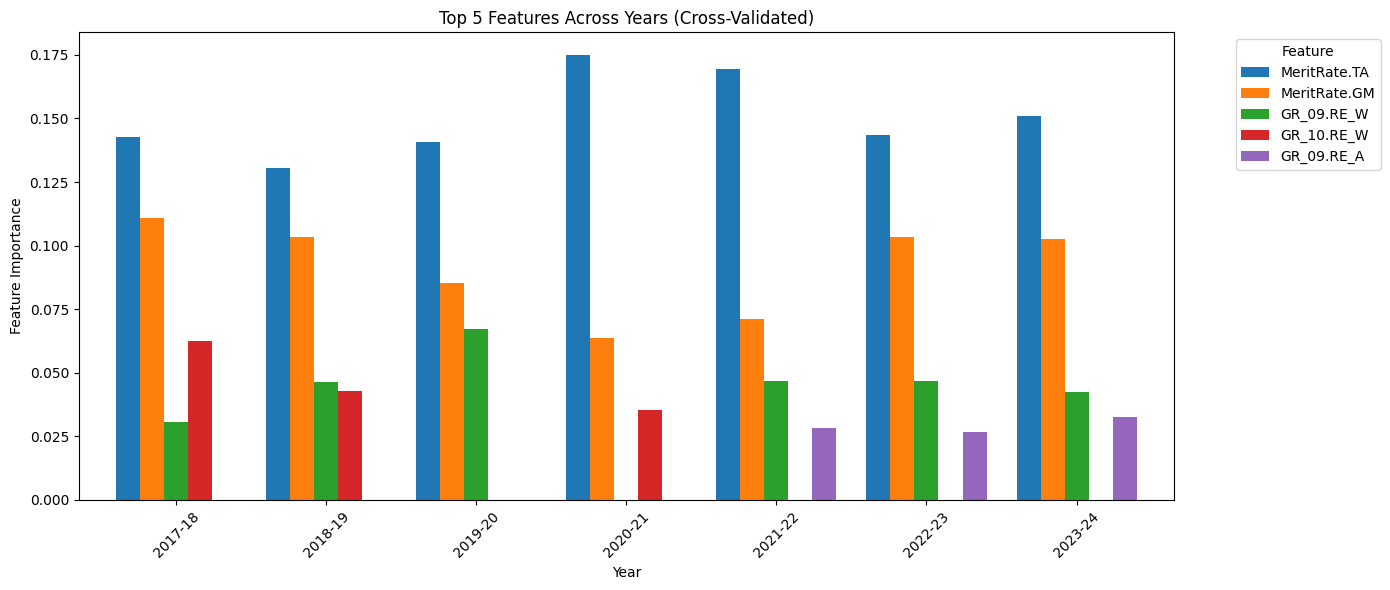

<Figure size 1400x600 with 0 Axes>

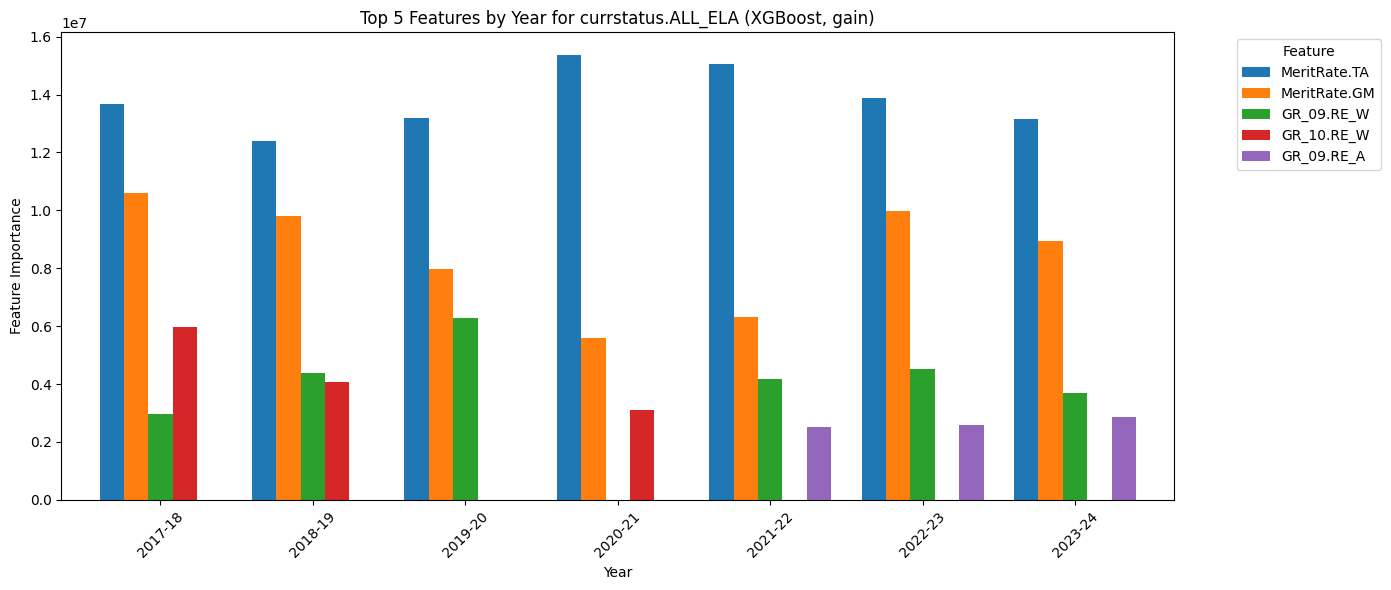

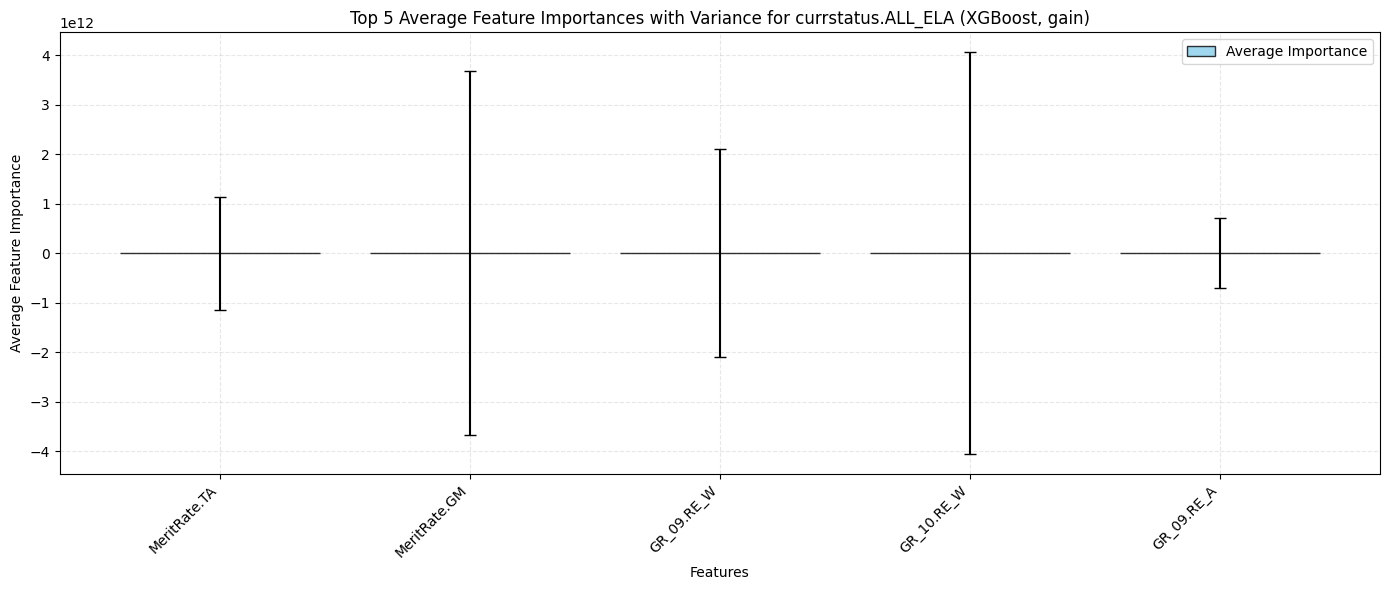

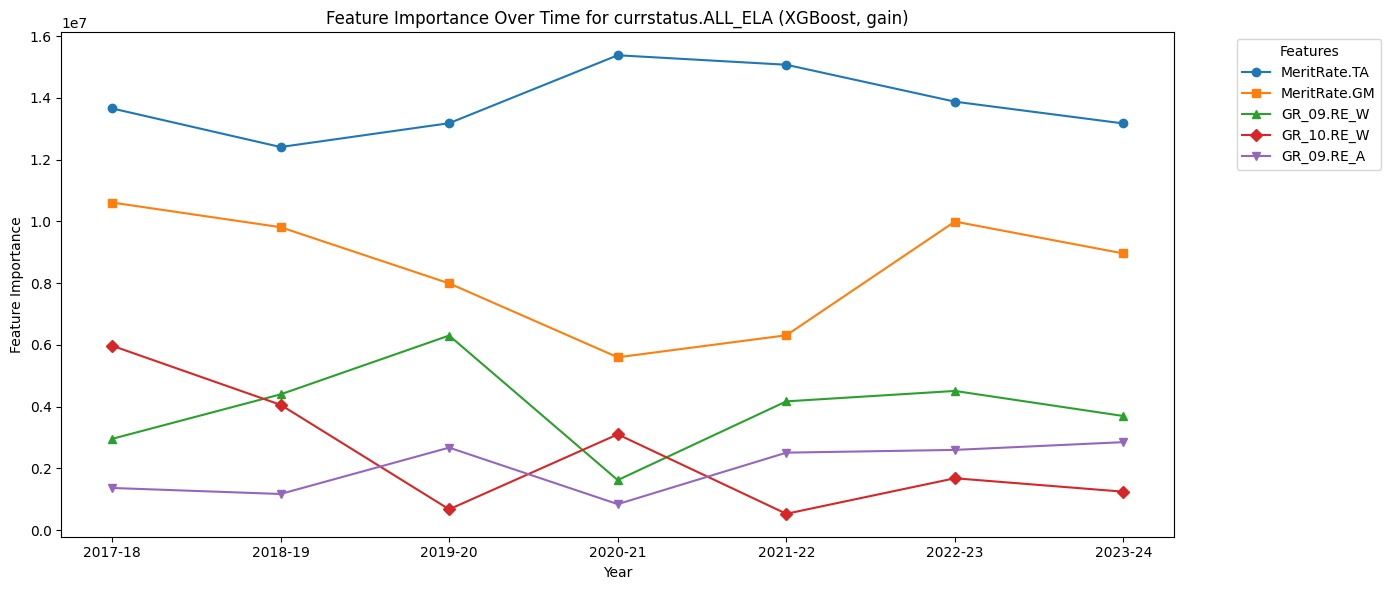

In [8]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features
)

## Random Forest

### MATH

In [9]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "currstatus.ALL_Math"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

KeyboardInterrupt: 

In [ ]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)

### ELA

In [ ]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "currstatus.ALL_ELA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

In [ ]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)